# Emittance minimization using Xopt with BAXGenerator running algorithm ScipyMinimizeEmittance
In this notebook we demonstrate the use of Xopt to perform Bayesian Algorithm Execution (BAX) as a means of minimizing the emittance described by a simple optical beam size model. BAX is a generalization of Bayesian Optimization that seeks to acquire observations that provide our model with maximal information about our property of interest. In this example, our property of interest is the minimal emittance and its location in tuning-parameter-space. See https://arxiv.org/pdf/2209.04587.pdf for details.

# Imports

In [1]:
# Ignore all warnings
import warnings
warnings.filterwarnings("ignore")

import sys
# sys.path.append('C:\\Users\\Dylan\\SLAC') #parent directory containing emitopt module

import matplotlib.pyplot as plt
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

import pandas as pd
import torch

from xopt import Xopt
from xopt.vocs import VOCS
from xopt.generators.bayesian.bax_generator import BaxGenerator

from xopt.evaluator import Evaluator

from emitopt.utils import (post_path_emit_squared_thick_quad,
                           compute_emit_bmag_thick_quad,
                           get_meas_scan_inputs_from_tuning_configs,
                           get_valid_geo_mean_emittance_samples_thick_quad)
from emitopt.algorithms import ScipyMinimizeEmittanceXY

import time
import numpy as np
import random

# Use CUDA if available

In [2]:
# if torch.cuda.is_available():
if False:
    torch.set_default_tensor_type('torch.cuda.DoubleTensor')
    use_cuda = True
else:
    torch.set_default_tensor_type('torch.DoubleTensor')
    use_cuda = False

# Notebook settings

In [3]:
ndim = 2 #number of input dimensions
noise = False #whether to add noise to the ground-truth beam size function outputs
meas_dim = 1 #input dimension for measurement parameter
n_obs_init = 50 #number of random initial observations for GP model
n_samples = 10 #number of posterior samples for BAX
n_iter = 1 #number of optimization steps for Xopt to take (after acquiring random initial data)
rand_seed = 2

#random seeds for reproducibility 
torch.manual_seed(rand_seed)
np.random.seed(rand_seed) #only affects initial random observations through Xopt
random.seed(rand_seed)

# Build test function from single-quadrupole optical beam size model 
Here we define a simple ground-truth beam size function for our optimization problem, where we attempt to find the location in tuning parameter space with minimal emittance. Note that the function "test_func" used to evaluate the ground-truth beam size function takes a dictionary as input and returns a dictionary as the output.

In [4]:
from pyemittance.emittance_calc import EmitCalc
from pyemittance.load_json_configs import load_configs
from pyemittance.simulation import BeamSim

CONFIG = load_configs('LCLS2_OTR0H04')
CONFIG['beamline_info']

q_len = CONFIG['beamline_info']['Lquad']
distance = CONFIG['beamline_info']['rMatx'][1]

In [5]:
BUNCH_PARAMS0 = {
    'total_charge': 50e-12,
    'norm_emit_x': 1e-6,
    'norm_emit_y': 2e-6,
    'beta_x': 10,
    'alpha_x': -1,
    'beta_y': 11,
    'alpha_y': -2,
    'energy': 80e6,
    'species':'electron'
}
sim = BeamSim(bunch_params=BUNCH_PARAMS0, beamline_info=CONFIG['beamline_info'])


# define variables functions
var_names = ['x' + str(i) for i in range(ndim)]
meas_param = var_names[meas_dim]

def measure_beamsize(input_dict):
    x_tuning = torch.tensor([])
    for key in input_dict.keys():
        if key is not meas_param:
            x_tuning = torch.cat((x_tuning, torch.tensor([input_dict[key]])))
    rms_beamsizes0 = np.array(sim.beam_size_meas(input_dict[meas_param]))
    detuning_scale = 1. + x_tuning.abs().sum()
    xrms, yrms = detuning_scale * rms_beamsizes0
    return {'xrms_sq': float(xrms)**2.*1.e6,
            'yrms_sq': float(yrms)**2.*1.e6} # mean-square beam sizes in mm squared

def ground_truth_emittance(x_tuning, emit_min_x=6.4008e-09, emit_min_y=1.2804e-08):
    detuning_scale = 1. + x_tuning.abs().sum(dim=1, keepdim=True)
    emit_xy = detuning_scale**2 * torch.tensor([emit_min_x, emit_min_y]).reshape(1,-1)
    emit = torch.sqrt(emit_xy[:,0] * emit_xy[:,1])
    return emit, emit_xy

# Construct vocs

In [6]:
variables = {var_name: [-2,2] for var_name in var_names}
variables[meas_param] = [-3,3] #overwrite bounds for measurement parameter to capture minimum of single-quadrupole optical model

#construct vocs
vocs = VOCS(
    variables = variables,
    observables = ['xrms_sq', 'yrms_sq']
)

print('variable_names =', vocs.variable_names)
print('meas_param =', "'" + meas_param + "'")
print('domain =\n', vocs.bounds.T)

variable_names = ['x0', 'x1']
meas_param = 'x1'
domain =
 [[-2.  2.]
 [-3.  3.]]


# Prepare generator options.
In this example, we use a specialty covariance module (Matern x Quadratic kernel) for our beam size model.

In [7]:
from gpytorch.kernels import MaternKernel, PolynomialKernel, ScaleKernel
from gpytorch.priors.torch_priors import GammaPrior

from xopt.generators.bayesian.models.standard import StandardModelConstructor
from xopt.generators.bayesian.bax_generator import BaxGenerator

# prepare custom covariance module
tuning_dims = list(range(vocs.n_variables))
tuning_dims.remove(meas_dim)
covar_module_x = (MaternKernel(ard_num_dims=len(tuning_dims), 
                              active_dims=tuning_dims, 
                              lengthscale_prior=None) * 
                              PolynomialKernel(power=2, active_dims=[meas_dim])
                 )

scaled_covar_module_x = ScaleKernel(covar_module_x)#, outputscale_prior=GammaPrior(2.0, 0.15))
covar_module_y = (MaternKernel(ard_num_dims=len(tuning_dims), 
                              active_dims=tuning_dims, 
                              lengthscale_prior=None) * 
                              PolynomialKernel(power=2, active_dims=[meas_dim])
                 )
scaled_covar_module_y =  ScaleKernel(covar_module_y)#, outputscale_prior=GammaPrior(2.0, 0.15))

# prepare options for Xopt generator
covar_module_dict = {'xrms_sq': scaled_covar_module_x,
                     'yrms_sq': scaled_covar_module_y}

model_constructor = StandardModelConstructor(covar_modules=covar_module_dict, use_low_noise_prior=True)

In [8]:
from xopt.numerical_optimizer import LBFGSOptimizer
numerical_optimizer = LBFGSOptimizer(
                                    n_raw_samples=20,
                                    n_restarts=10,
                                    max_iter=50)

# Construct generator, evaluator, Xopt objects

In [9]:
#Prepare Algorithm
from emitopt.utils import get_quad_strength_conversion_factor
scale_factor = get_quad_strength_conversion_factor(E=.08, q_len=q_len)
# scale_factor = 1.
algo_kwargs = {
        'model_names_ordered': ['xrms_sq', 'yrms_sq'],
        'scale_factor': scale_factor,
        'q_len': q_len,
        'distance': distance,
        'n_samples': n_samples,
        'meas_dim': meas_dim,
        'n_steps_measurement_param': 11,
        'n_steps_exe_paths':  11,
#         'scipy_options': {'gtol':1.e-8},
}
algo = ScipyMinimizeEmittanceXY(**algo_kwargs)

#construct BAX generator
generator = BaxGenerator(vocs=vocs, 
                         model_constructor=model_constructor, 
                         numerical_optimizer=numerical_optimizer,
                         algorithm=algo, 
                         use_cuda=use_cuda)

#construct evaluator
evaluator = Evaluator(function=measure_beamsize)

#construct Xopt optimizer
optimizer = Xopt(evaluator=evaluator, generator=generator, vocs=vocs)

# Optimize

In [10]:
# call X.random_evaluate() to generate random initial points and evaluate on test_func
optimizer.random_evaluate(n_obs_init)

,x0,x1,xrms_sq,yrms_sq,xopt_runtime,xopt_error
1,0.256020,-0.265249,0.220062,0.326733,0.007661,False
2,1.896295,2.507430,0.427298,15.450564,0.000213,False
3,-0.198650,0.801946,0.032805,0.911911,0.000177,False
4,0.258710,-2.105103,0.951806,0.036802,0.000172,False
5,0.318529,0.562350,0.069121,0.899436,0.000175,False
6,0.678661,2.836786,0.240489,6.065923,0.000170,False
7,1.181405,1.516937,0.015986,5.045368,0.000171,False
8,-0.477084,2.597134,0.129609,4.197641,0.000169,False
9,0.801381,-2.963112,3.033502,0.530678,0.000175,False
10,0.932691,-2.823482,3.268818,0.490423,0.000172,False


In [11]:
# results = {}
# beam_size_models = {}

for i in range(1, n_iter+1):

    print('Iteration:', i, '/', n_iter)

    start = time.time()

    # call X.step() to generate a random initial point and evaluate on test_func
    optimizer.step()    

    
    #extract GP models
    model = optimizer.generator.train_model()
    bax_model_ids = [optimizer.generator.vocs.output_names.index(name)
                            for name in optimizer.generator.algorithm.model_names_ordered]
    bax_model = model.subset_output(bax_model_ids)
    beam_size_model_x = bax_model.models[0]
    beam_size_model_y = bax_model.models[1]
    
    #extract and store algorithm results for this iteration
#     results[i] = optimizer.generator.algorithm_results
#     beam_size_models[i] = beam_size_model

    
    end = time.time()
    print('This iteration took:', end-start, 'seconds.\n')

Iteration: 1 / 1
This iteration took: 4.148067235946655 seconds.



# Minimize sample emittance functions produced by current GP beam size model and inspect results

In [12]:
#select sample result

sid = 5 #sample index to examine

X_tuned = optimizer.generator.algorithm_results['x_stars'][sid:sid+1, :]
print('X_tuned =', X_tuned)

X_tuned = tensor([[0.2444]])


# Sample geometric mean of emittance x&y

X_tuned = tensor([[0.2444]])


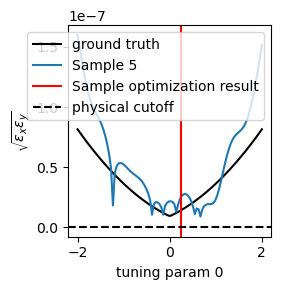

In [13]:
from emitopt.plotutils import plot_pathwise_sample_emittance_minimization_results
plot_pathwise_sample_emittance_minimization_results(optimizer, sid=5, ground_truth_emittance_fn=ground_truth_emittance)

# Plot posterior mean model of geometric mean emttance x&y

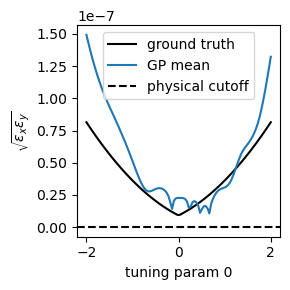

In [15]:
from emitopt.plotutils import plot_posterior_mean_modeled_emittance
plot_posterior_mean_modeled_emittance(optimizer, X_tuned, ground_truth_emittance)

In [15]:
X_tuned = optimizer.generator.algorithm_results['x_stars'][sid:sid+1, :]
X_tuned

tensor([[0.2444]])

x_tuning: tensor([[0.2444]])


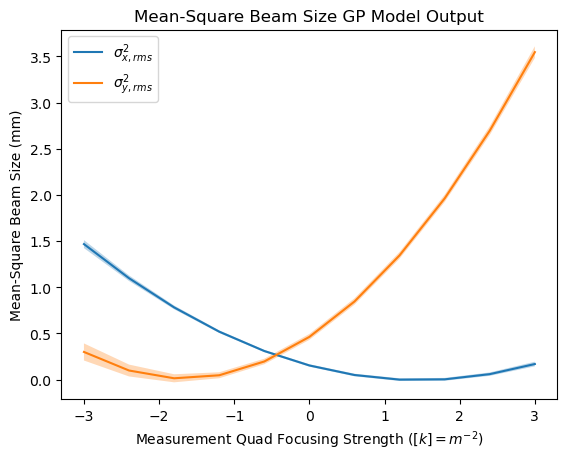

In [16]:
from emitopt.plotutils import plot_beam_size_squared_at_x_tuning
plot_beam_size_squared_at_x_tuning(optimizer, x_tuning=X_tuned)

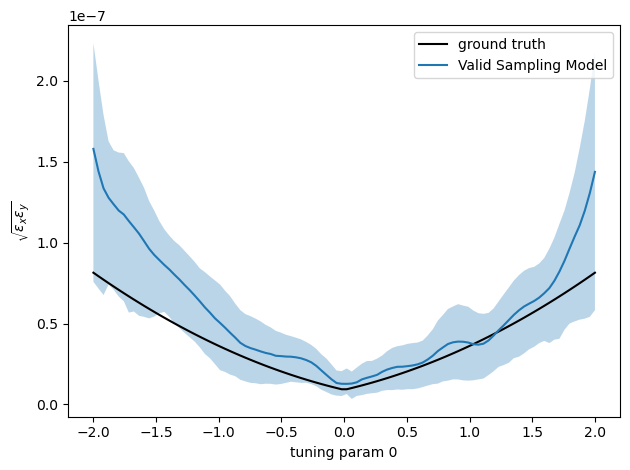

In [20]:
from emitopt.utils import get_valid_geo_mean_emittance_samples_thick_quad


for scan_dim in range(ndim-1):
    X_tuning_scan = X_tuned.repeat(100,1)
    ls = torch.linspace(-2,2,100)
    X_tuning_scan[:,scan_dim] = ls
    X_meas = torch.linspace(-3,3,11)
    
    emit_mean, emit_lower, emit_upper = torch.tensor([]), torch.tensor([]), torch.tensor([])
    for i in range(len(X_tuning_scan)):
        emit_valid, emit_x_valid, emit_y_valid, sample_validity_rate = get_valid_geo_mean_emittance_samples_thick_quad(
            model=bax_model,
            scale_factor=optimizer.generator.algorithm.scale_factor,
            q_len=optimizer.generator.algorithm.q_len,
            distance=optimizer.generator.algorithm.distance,
            x_tuning=X_tuning_scan[i:i+1],
            domain=optimizer.generator.vocs.bounds.T,
            meas_dim=meas_dim,
            n_samples=10000,
            n_steps_quad_scan=10,
            visualize=False,
        )
        mean = emit_valid.mean()
        lower = torch.quantile(emit_valid, q=0.025)
        upper = torch.quantile(emit_valid, q=0.975)
        emit_mean = torch.cat((emit_mean, torch.tensor([mean])))
        emit_lower = torch.cat((emit_lower, torch.tensor([lower])))
        emit_upper = torch.cat((emit_upper, torch.tensor([upper])))

    gt_emits, gt_emit_xy = ground_truth_emittance(x_tuning=X_tuning_scan)
    plt.plot(ls, gt_emits, c='k', label='ground truth')
    plt.plot(ls, emit_mean*1.e-6, label='Valid Sampling Model')
    plt.fill_between(ls, emit_lower*1.e-6, emit_upper*1.e-6, alpha=0.3)
    plt.xlabel('tuning param ' + str(scan_dim))
    plt.ylabel('$\sqrt{\epsilon_x\epsilon_y}$')
#     plt.ylim(0,1.81e-7)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Look at only emit_x or emit_y

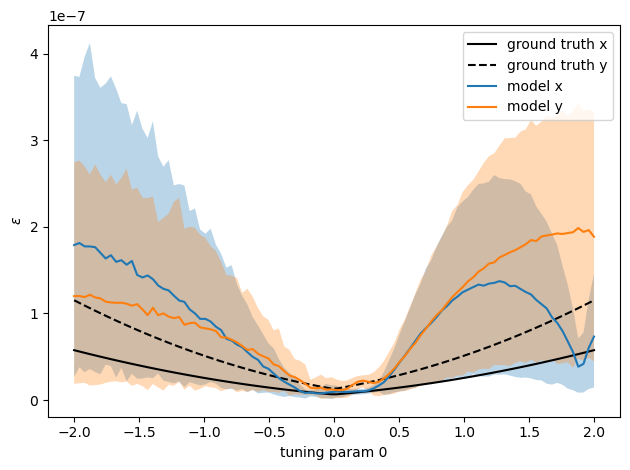

In [30]:
from emitopt.utils import get_valid_geo_mean_emittance_samples_thick_quad

for scan_dim in range(ndim-1):
    X_tuning_scan = X_tuned.repeat(100,1)
    ls = torch.linspace(-2,2,100)
    X_tuning_scan[:,scan_dim] = ls
    X_meas = torch.linspace(-3,3,11)
    
    
    emit_means, emit_lowers, emit_uppers = torch.tensor([]), torch.tensor([]), torch.tensor([])

    for i in range(len(X_tuning_scan)):
        emit_valid, emit_x_valid, emit_y_valid, sample_validity_rate = get_valid_geo_mean_emittance_samples_thick_quad(
            model=bax_model,
            scale_factor=optimizer.generator.algorithm.scale_factor,
            q_len=optimizer.generator.algorithm.q_len,
            distance=optimizer.generator.algorithm.distance,
            x_tuning=X_tuning_scan[i:i+1],
            domain=optimizer.generator.vocs.bounds.T,
            meas_dim=meas_dim,
            n_samples=10000,
            n_steps_quad_scan=10,
            visualize=False,
        )
        
        means = []
        lowers = []
        uppers = []
        for emit in [emit_x_valid, emit_y_valid]:
            means += [emit.mean()]
            lowers += [torch.quantile(emit, q=0.025)]
            uppers += [torch.quantile(emit, q=0.975)]
          
        emit_means = torch.cat((emit_means, torch.tensor(means).reshape(1,-1)))
        emit_lowers = torch.cat((emit_lowers, torch.tensor(lowers).reshape(1,-1)))
        emit_uppers = torch.cat((emit_uppers, torch.tensor(uppers).reshape(1,-1)))
        
    gt_emits, gt_emit_xy = ground_truth_emittance(x_tuning=X_tuning_scan)
    plt.plot(ls, gt_emit_xy[:,0], c='k', label='ground truth x')
    plt.plot(ls, gt_emit_xy[:,1], c='k', ls='--', label='ground truth y')
    plt.plot(ls, emit_means[:,0]*1.e-6, label='model x')
    plt.plot(ls, emit_means[:,1]*1.e-6, label='model y')
    plt.fill_between(ls, emit_lowers[:,0]*1.e-6, emit_uppers[:,0]*1.e-6, alpha=0.3)
    plt.fill_between(ls, emit_lowers[:,1]*1.e-6, emit_uppers[:,1]*1.e-6, alpha=0.3)
    plt.xlabel('tuning param ' + str(scan_dim))
    plt.ylabel('$\epsilon$')
#     plt.ylim(0,1.81e-7)
    plt.legend()
    
    
    
    plt.tight_layout()
    plt.show()